In [298]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import metrics


In [299]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
# Use the ratings.csv file
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
)
movielens_zipped_file = keras.utils.get_file(
    "ml-1m.zip", movielens_data_file_url, extract=False
)
keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

ratings_file = movielens_dir / "ratings.dat"

df_base = pd.read_csv(ratings_file, sep='::', engine='python', names=['userId', 'movieId', 'rating', 'timestamp'])

user_df = pd.read_csv(movielens_dir / "users.dat", sep='::', engine='python', names=['userId', 'gender', 'age', 'ocupation', 'zipCode'])

user_df.head()


,userId,gender,age,ocupation,zipCode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [300]:
# get movies that was rated at least 1000 times and user who rated at least 50 of these movies
df = df_base.groupby('movieId').filter(lambda x: len(x) >= 500).groupby('userId').filter(lambda x: len(x) >= 50)
# df = df_base
df.shape

(526643, 4)

In [301]:
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
def encode_gender(gender):
  return 1 if gender == 'F' else 0

userGender = {x[0]: encode_gender(x[1]) for x in user_df.values}
userGender_encoded = {i: userGender[userencoded2user[i]] for i in userencoded2user}

movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)
df["gender"] = df["userId"].map(userGender)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 3571, Number of Movies: 618, Min rating: 1.0, Max rating: 5.0


In [302]:
total = df.shape[0]
women = df.loc[df['gender'] == 1].shape[0]
men = df.loc[df['gender'] == 0].shape[0]

print(women / total, men / total, total)

0.2255208936604113 0.7744791063395887 526643


In [303]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
# y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
y = df[["rating", "gender", "movie", "user"]].values
# y_ = df[["rating", "gender", "movie"]]
# y_["rating"] = y_["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
# y = y_.values

# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.8 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

y

array([[4.000e+00, 0.000e+00, 4.330e+02, 2.148e+03],
       [5.000e+00, 1.000e+00, 1.080e+02, 3.930e+02],
       [5.000e+00, 0.000e+00, 3.980e+02, 3.294e+03],
       ...,
       [5.000e+00, 0.000e+00, 1.000e+01, 2.445e+03],
       [5.000e+00, 0.000e+00, 5.160e+02, 8.940e+02],
       [5.000e+00, 0.000e+00, 2.960e+02, 8.280e+02]])

In [314]:
EMBEDDING_SIZE = 20

def custom_mean_squared_error(data, y_pred):    
  y_true = tf.reshape(data[:, 0], (tf.shape(data)[0], 1))
  return keras.losses.mean_squared_error(y_true, y_pred) + value_unfairness(data, y_pred)


def ndcg(y_true, y_pred):  
  y_true_matrix = np.zeros((num_users, num_movies))
  y_pred_matrix = np.zeros((num_users, num_movies))

  for r, g, i, u in y_true:    
    y_true_matrix[int(u), int(i)] = r
  
  y_pred_np = np.concatenate((y_pred, y_true[:, 1:]), 1)
  for r, g, i, u in y_pred_np:    
    y_pred_matrix[int(u), int(i)] = r

  return metrics.ndcg_score(y_true_matrix, y_pred_matrix, k=10)

def value_unfairness(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  women_pred = tf.boolean_mask(y_pred, gender_mask)
  men_pred = tf.boolean_mask(y_pred, tf.logical_not(gender_mask))
  women_true = tf.boolean_mask(y_true[:, 0], gender_mask)
  men_true = tf.boolean_mask(y_true[:, 0], tf.logical_not(gender_mask))

  return keras.backend.pow(keras.backend.mean((women_pred - women_true) ** 2) - keras.backend.mean((men_pred - men_true)**2), 2)

def value_unfairness_women(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  women_pred = tf.boolean_mask(y_pred, gender_mask)  
  women_true = tf.boolean_mask(y_true[:, 0], gender_mask)  

  return keras.backend.mean((women_pred - women_true) ** 2)

def value_unfairness_men(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool) 
  men_pred = tf.boolean_mask(y_pred, tf.logical_not(gender_mask))  
  men_true = tf.boolean_mask(y_true[:, 0], tf.logical_not(gender_mask))

  return keras.backend.mean((men_pred - men_true) ** 2)

def parity(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  women_pred = tf.boolean_mask(y_pred, gender_mask)
  men_pred = tf.boolean_mask(y_pred, tf.logical_not(gender_mask))
  error = keras.backend.mean(women_pred) - keras.backend.mean(men_pred)
  return keras.backend.abs(error)

def parity_women(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  women_pred = tf.boolean_mask(y_pred, gender_mask)  
  return keras.backend.mean(women_pred)

def parity_men(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  men_pred = tf.boolean_mask(y_pred, tf.logical_not(gender_mask))
  return keras.backend.mean(men_pred)

def parity_reg(y_true, y_pred):
  gender_mask = tf.cast(y_true[:, 1], tf.bool)
  women_pred = tf.boolean_mask(y_pred, gender_mask)
  men_pred = tf.boolean_mask(y_pred, tf.logical_not(gender_mask))
  error = keras.backend.mean(women_pred) - keras.backend.mean(men_pred)
  abs = keras.backend.abs(error)

  return tf.where(abs < 1.0, keras.backend.pow(error, 2), abs)  

def root_mean_squared_error(data, y_pred):
  y_true = tf.reshape(data[:, 0], (tf.shape(data)[0], 1))
  return keras.backend.sqrt(keras.backend.mean(tf.math.squared_difference(y_true, y_pred)))

class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(
            num_users, 
            1,  
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)              
        )
        self.movie_bias = layers.Embedding(
            num_movies, 
            1,
            embeddings_regularizer=keras.regularizers.l2(1e-6) 
        )        

    def call(self, inputs):        
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        # return tf.nn.sigmoid(x)              
        return x


model = keras.Sequential()
model.add(RecommenderNet(num_users, num_movies, EMBEDDING_SIZE, name="RecommenderNet"))


model.compile(
    loss=custom_mean_squared_error, 
    optimizer=keras.optimizers.Adam(lr=0.0002),
    metrics=[root_mean_squared_error, parity, value_unfairness, parity_women, parity_men, value_unfairness_women, value_unfairness_men]    
)

x_train.shape[0]

421314

In [315]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=20,
    verbose=1,
    validation_data=(x_val, y_val),
)


Epoch 1/20
3292/3292 [==============================] - 12s 3ms/step - loss: 15.5387 - root_mean_squared_error: 3.6096 - parity: 0.0072 - value_unfairness: 2.0973 - parity_women: 0.3193 - parity_men: 0.3200 - value_unfairness_women: 13.5519 - value_unfairness_men: 13.4189 - val_loss: 1.2053 - val_root_mean_squared_error: 1.0471 - val_parity: 0.0085 - val_value_unfairness: 0.1046 - val_parity_women: 3.6727 - val_parity_men: 3.6757 - val_value_unfairness_women: 1.1423 - val_value_unfairness_men: 1.1121
Epoch 2/20
3292/3292 [==============================] - 9s 3ms/step - loss: 1.2027 - root_mean_squared_error: 1.0426 - parity: 0.0083 - value_unfairness: 0.1114 - parity_women: 3.7091 - parity_men: 3.7117 - value_unfairness_women: 1.1399 - value_unfairness_men: 1.1065 - val_loss: 1.1907 - val_root_mean_squared_error: 1.0445 - val_parity: 0.0112 - val_value_unfairness: 0.0956 - val_parity_women: 3.5659 - val_parity_men: 3.5710 - val_value_unfairness_women: 1.1681 - val_value_unfairness_men:

In [316]:
y_pred = model.predict(x_val, batch_size=128)
print(ndcg(y_val, y_pred))

0.8993038320883711


In [127]:
antidote_data = []
budget = int(0.01 * num_users)
mean_rating = np.mean(y_train[:, 0])

for u in range(num_users, num_users + budget):
  for i in range(0, num_movies):
    antidote_data.append([u, i, mean_rating, 0, 0])

df_antidote = pd.DataFrame(antidote_data)
df_antidote = df_antidote.sample(frac=1, random_state=42)

x_antidote = df_antidote[[0, 1]].values
y_antidote = df_antidote[[2, 3, 4]].values


In [128]:
optimizer = tf.keras.optimizers.Adam(lr=0.01)

for i in range(0, 5):

  model = keras.Sequential()
  model.add(RecommenderNet(num_users + budget, num_movies, EMBEDDING_SIZE, name="RecommenderNet"))


  model.compile(
      loss=custom_mean_squared_error, 
      optimizer=keras.optimizers.Adam(lr=0.0002),
      metrics=[root_mean_squared_error, parity, value_unfairness]
  )

  model.fit(
    x=tf.concat([x_train, x_antidote], 0),
    y=tf.concat([y_train, y_antidote], 0),
    batch_size=128,
    epochs=5,
    verbose=1,
    validation_data=(x_val, y_val),
  )

  y_true = tf.convert_to_tensor(y_train, dtype=tf.float32)

  print(y_antidote)
  with tf.GradientTape() as tape:

        y_antidote_tensor = tf.convert_to_tensor(y_antidote, dtype=tf.float32)
        tensor_y_antidote = tf.Variable(tf.reshape(y_antidote_tensor[:, 0], (tf.shape(y_antidote_tensor)[0], 1)))

        # Forward pass.        
        y_pred = tf.Variable(model.predict(x_train, batch_size=128))                    
        
        # Loss value for this batch.        
        loss_value = parity(x_train, y_pred)

  # Get gradients of loss wrt the weights.
  gradients = tape.gradient(loss_value, y_pred)



  # Update the weights of the model.
  optimizer.apply_gradients(zip([gradients[-tensor_y_antidote.shape[0]:]], [tensor_y_antidote]))

  y_antidote = np.concatenate((tensor_y_antidote.numpy(), y_antidote[:, 1:]), axis=1)


Epoch 1/5
7989/7989 [==============================] - 27s 3ms/step - loss: 7.9785 - root_mean_squared_error: 2.5529 - parity: 0.0249 - value_unfairness: 0.2050 - val_loss: 1.2897 - val_root_mean_squared_error: 1.1335 - val_parity: 0.0221 - val_value_unfairness: 0.1852
Epoch 2/5
7989/7989 [==============================] - 25s 3ms/step - loss: 0.8613 - root_mean_squared_error: 0.9256 - parity: 0.0310 - value_unfairness: 0.1906 - val_loss: 1.0185 - val_root_mean_squared_error: 1.0073 - val_parity: 0.0464 - val_value_unfairness: 0.1738
Epoch 3/5
7989/7989 [==============================] - 25s 3ms/step - loss: 0.7764 - root_mean_squared_error: 0.8786 - parity: 0.0546 - value_unfairness: 0.1713 - val_loss: 0.9436 - val_root_mean_squared_error: 0.9693 - val_parity: 0.0636 - val_value_unfairness: 0.1675
Epoch 4/5
7989/7989 [==============================] - 26s 3ms/step - loss: 0.7388 - root_mean_squared_error: 0.8569 - parity: 0.0706 - value_unfairness: 0.1742 - val_loss: 0.9109 - val_root

KeyboardInterrupt: ignored

In [ ]:
movie_df = pd.read_csv(movielens_dir / "movies.dat", sep='::', engine='python', names=['movieId', 'title', 'genres'])

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Showing recommendations for user: {}".format(user_id))
print("====" * 9)
print("Movies with high ratings from user")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)


Showing recommendations for user: 2237
Movies with high ratings from user
--------------------------------
Colonel Chabert, Le (1994) : Drama|Romance|War
Age of Innocence, The (1993) : Drama
When Harry Met Sally... (1989) : Comedy|Romance
Simple Plan, A (1998) : Crime|Thriller
Bull Durham (1988) : Comedy
--------------------------------
Top 10 movie recommendations
--------------------------------
Taxi Driver (1976) : Drama|Thriller
To Live (Huozhe) (1994) : Drama
Celluloid Closet, The (1995) : Documentary
Silence of the Lambs, The (1991) : Drama|Thriller
Wild Bunch, The (1969) : Western
Fargo (1996) : Crime|Drama|Thriller
Wrong Trousers, The (1993) : Animation|Comedy
Paths of Glory (1957) : Drama|War
Life Is Beautiful (La Vita � bella) (1997) : Comedy|Drama
American History X (1998) : Drama


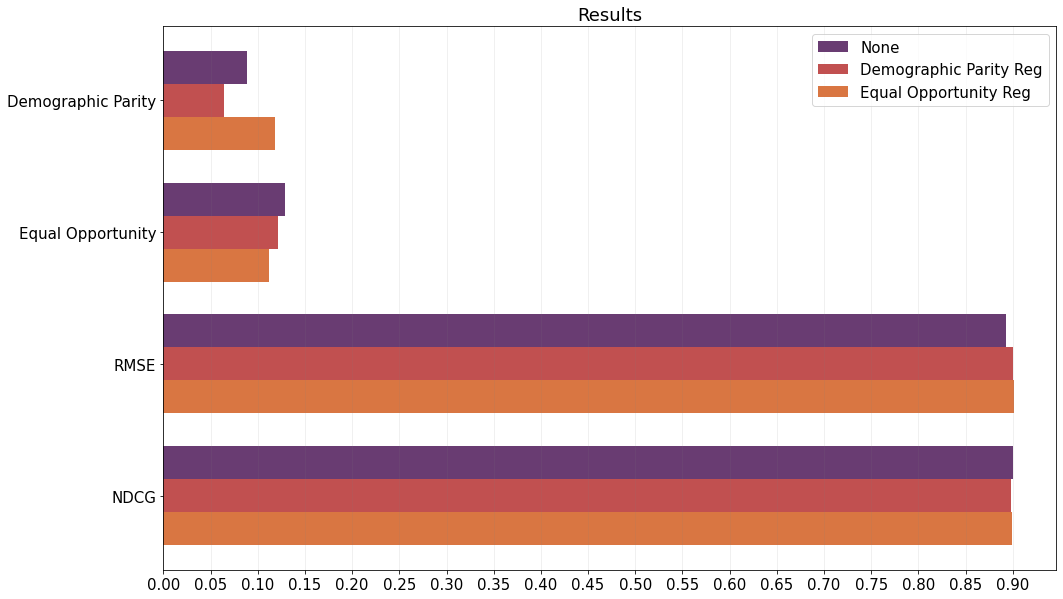

In [317]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

plt.rc('font', size=15)  

test_names = ['NDCG', 'RMSE', 'Equal Opportunity',  'Demographic Parity']
width = 0.25
fig, ax1 = plt.subplots(figsize=(16, 10))  # Create the figure


pos = np.arange(len(test_names))

# rects = ax1.barh(pos, [0.8899, 0.0886, 0.1315],
#                   width,
#                   color='#693c72',
#                   align='center',
#                   label='None',                 
#                   tick_label=test_names)

rects = ax1.barh(pos + width, [0.9004765132937749, 0.8924, 0.1284, 0.0886],
                  width,
                  color='#693c72',
                  align='center',
                  label='None',                 
                  tick_label=test_names)

rects = ax1.barh(pos, [0.8984680851902723, 0.9, 0.1213, 0.0640],
                  width,
                  color='#c15050',
                  align='center',
                  label='Demographic Parity Reg',                 
                  tick_label=test_names)

rects = ax1.barh(pos - width, [0.8993038320883711, 0.9008, 0.1121, 0.1182],
                  width,
                  color='#d97642',
                  align='center',
                  label='Equal Opportunity Reg',                 
                  tick_label=test_names)


ax1.set_title('Results')
ax1.xaxis.set_major_locator(MaxNLocator(20))
ax1.xaxis.grid(True, which='major' ,
                   color='grey', alpha=.15)
ax1.set_yticks(pos)
ax1.legend()

fig.show()

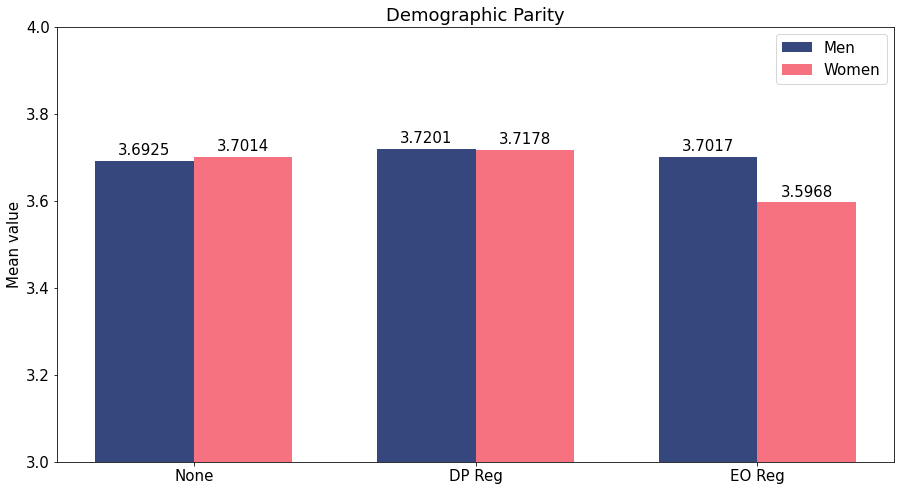

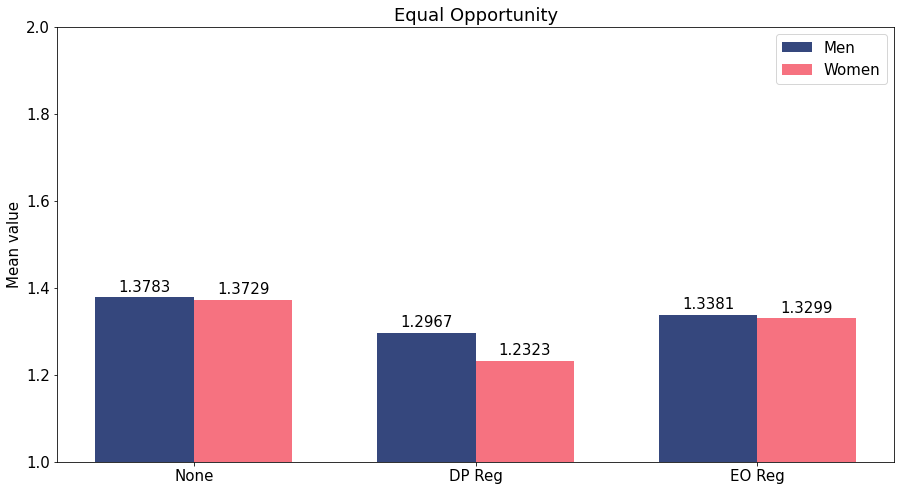

In [320]:
def autolabel(rects, ax):
  """Attach a text label above each bar in *rects*, displaying its height."""
  for rect in rects:
      height = rect.get_height()
      ax.annotate('{}'.format(height),
                  xy=(rect.get_x() + rect.get_width() / 2, height),
                  xytext=(0, 3),  # 3 points vertical offset
                  textcoords="offset points",
                  ha='center', va='bottom')

def bar_plot(labels, women_data, men_data, title, ylabel, lower, upper):    
  plt.rc('font', size=15) 
  x = np.arange(len(labels))  # the label locations
  width = 0.35  # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, men_data, width, label='Men', color='#35477d')
  rects2 = ax.bar(x + width/2, women_data, width, label='Women', color='#f67280')
  

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(ylabel)
  ax.set_ybound(lower=lower, upper=upper)
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()


  autolabel(rects1, ax)
  autolabel(rects2, ax)

  
  fig.set_figwidth(15)
  fig.set_figheight(8)

  plt.show()

bar_plot(['None', 'DP Reg', 'EO Reg'], [3.7014, 3.7178, 3.5968], [3.6925, 3.7201, 3.7017], 'Demographic Parity',  'Mean value', 3, 4)
bar_plot(['None', 'DP Reg', 'EO Reg'], [1.3729, 1.2323, 1.3299], [1.3783, 1.2967, 1.3381], 'Equal Opportunity',  'Mean value', 1, 2)